<a href="https://colab.research.google.com/github/CShorten/NL2NAC/blob/main/Parameter_Count_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip Parameter_Counts.zip
!unzip Code_Strings.zip

In [3]:
import pandas as pd
df = pd.DataFrame()

In [4]:
test = open("./Parameter_Counts/5-512-stride-1-512-stride-2-128-stride-1-1024-stride-2-64-stride-1-2-512-512-.txt")

In [5]:
content = test.readlines()
content

['Model: "model_7"\n',
 '_________________________________________________________________\n',
 ' Layer (type)                Output Shape              Param #   \n',
 '=================================================================\n',
 ' input_8 (InputLayer)        [(None, 32, 32, 3)]       0         \n',
 '                                                                 \n',
 ' conv2d_49 (Conv2D)          (None, 32, 32, 64)        1792      \n',
 '                                                                 \n',
 ' conv2d_50 (Conv2D)          (None, 30, 30, 512)       295424    \n',
 '                                                                 \n',
 ' conv2d_51 (Conv2D)          (None, 14, 14, 512)       2359808   \n',
 '                                                                 \n',
 ' conv2d_52 (Conv2D)          (None, 12, 12, 128)       589952    \n',
 '                                                                 \n',
 ' conv2d_53 (Conv2D)          (None, 5, 

In [10]:
param_count = content[-4]
param_count = param_count.replace("Total params: ", "")
param_count = param_count.replace("\n", "")
param_count = param_count.replace(",", "")
param_count

'5580746'

In [15]:
test = {}

test["b"] = [0, "hello"]

test["b"][0] = 5
test

{'b': [5, 'hello']}

In [17]:
import os
data_dict = {}

for file_name in os.listdir("./Parameter_Counts"):
  if ".DS_Store" not in file_name:
    parameter_count_file = open("./Parameter_Counts/"+file_name)
    parser = parameter_count_file.readlines()
    parser = parser[-4]
    parser = parser.replace("Total params: ", "")
    parser = parser.replace("\n", "")
    parser = parser.replace(",", "")
    parser = int(parser)
    data_dict[file_name] = [0,"insert code here"]
    data_dict[file_name][0] = parser

In [19]:
for file_name in os.listdir("./Code_Strings"):
  if ".DS_Store" not in file_name:
    code_string_file = open("./Code_Strings/"+file_name)
    str_parser = code_string_file.readlines()
    content = ""
    for line in str_parser:
      content += line
      content += " "
    data_dict[file_name][1] = content

In [22]:
architecture_codes = []
labels = []
for key in data_dict.keys():
  labels.append(data_dict[key][0])
  architecture_codes.append(data_dict[key][1])

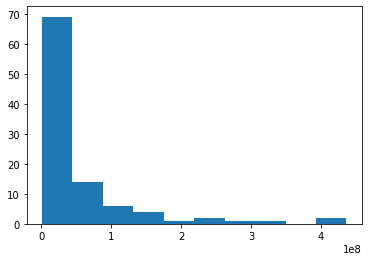

In [24]:
import matplotlib.pyplot as plt

plt.hist(labels);

In [29]:
from numpy import median

median(labels)

18784074.0

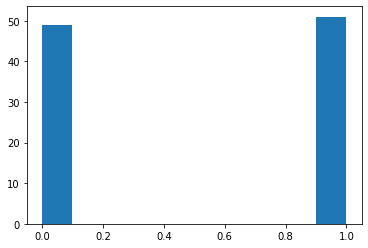

In [30]:
binary_labels = []

for label in labels:
  if label < 18_000_000:
    binary_labels.append(0)
  else:
    binary_labels.append(1)

plt.hist(binary_labels);

In [31]:
len(architecture_codes[0])

773

In [35]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
len(word_tokenize(architecture_codes[0]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


193

In [37]:
tokenized_descriptions = []

for description in architecture_codes:
  tokenized_descriptions.append(word_tokenize(description))

token2idx = {}
counter = 1
for tokenized_description in tokenized_descriptions:
  for token in tokenized_description:
    if token not in token2idx.keys():
      # add not in stop_words here for the future
      token2idx[token] = counter
      counter += 1

# token dictionary token2idx["hello"] = 5
# that index tells us where to put the count in the sparse vector

# get counts
tf_vectors = []
for tokenized_description in tokenized_descriptions:
  new_count_dict = {}
  for token in tokenized_description:
    if token in new_count_dict.keys():
      new_count_dict[token] += 1
    else:
      new_count_dict[token] = 1
    new_vector = [0] * (len(token2idx.keys()) + 1)
    for token in new_count_dict.keys():
      # stop_words filter
      new_vector[token2idx[token]] = new_count_dict[token]
  tf_vectors.append(new_vector)

In [41]:
len(tf_vectors[2])

37

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_vectors, binary_labels, test_size=0.2, random_state=42)

In [44]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=0)

In [45]:
train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

from sklearn.metrics import accuracy_score

print(accuracy_score(train_preds, y_train))

print(accuracy_score(test_preds, y_test))

0.8875
0.7


In [52]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth=8, random_state=0)

dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, random_state=0)

In [53]:
dtree_train_preds = dtree.predict(X_train)
dtree_test_preds = dtree.predict(X_test)

print(accuracy_score(dtree_train_preds, y_train))
print(accuracy_score(dtree_test_preds, y_test))

1.0
0.65


In [54]:
import tensorflow as tf
import keras

input = keras.layers.Input(shape=(37,))
x = keras.layers.Dense(512, activation="relu")(input)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs = input, outputs = output)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="BinaryCrossentropy", metrics = "accuracy", optimizer=opt)

In [55]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_test, y_test))

Epoch 1/200
2/2 [==============================] - 2s 738ms/step - loss: 2.3438 - accuracy: 0.4750 - val_loss: 8.0848 - val_accuracy: 0.2000
Epoch 2/200
2/2 [==============================] - 0s 45ms/step - loss: 3.6436 - accuracy: 0.5625 - val_loss: 1.0669 - val_accuracy: 0.8000
Epoch 3/200
2/2 [==============================] - 0s 49ms/step - loss: 2.8582 - accuracy: 0.4375 - val_loss: 0.5221 - val_accuracy: 0.8000
Epoch 4/200
2/2 [==============================] - 0s 59ms/step - loss: 0.7270 - accuracy: 0.5625 - val_loss: 3.2477 - val_accuracy: 0.2000
Epoch 5/200
2/2 [==============================] - 0s 47ms/step - loss: 1.8247 - accuracy: 0.5625 - val_loss: 2.1820 - val_accuracy: 0.2000
Epoch 6/200
2/2 [==============================] - 0s 46ms/step - loss: 1.1443 - accuracy: 0.5625 - val_loss: 0.5311 - val_accuracy: 0.8000
Epoch 7/200
2/2 [==============================] - 0s 47ms/step - loss: 0.8543 - accuracy: 0.4375 - val_loss: 0.5050 - val_accuracy: 0.8000
Epoch 8/200
2/2 [==

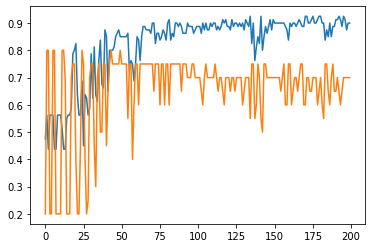

In [56]:
import matplotlib.pyplot

plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);